# **Hands-On: Open Cluster Membership Determination using Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) and Gaussian Mixture Model (GMM) - Part 1** 

Authors : Salma Zahra Fadiyah, Irfan Imaduddin, M. Ikbal Arifyanto <br>
Version : 1.0 <br>
Date : 22 July 2021 <br>
Contact : salmazahraa[at]gmail[dot]com <br>

---

## Welcome!

<p align = "justify">  In this workshop, we will determine the cluster members of an open cluster using Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) and Gaussian Mixture Model (GMM). This is the first part of two hands-on series. The second part will be held tomorrow (21/08/07). The open cluster data that will be used is NGC 752 from Gaia Early Data Release 3 (eDR3). </p> 

Hands-on part two: [day07_handson_gmm.ipynb]()


## 1. Introduction

<p align = "justify"> Open clusters have long been regarded as powerful tools for studies of the Galactic disk and evolution of stars (Chen, 2003). Membership determination is the first step to study an open cluster, which can directly influence estimation of physical parameters. Various methods have been used for membership determination based on proper motions, radial velocities, photometric data and their combination.
</p>
<p align = "justify"> Various algorithms have been developed for the determination of star cluster membership. Machine-learning applications for this case were introduced such as DBSCAN (Gao, 2014), Gaussian Mixture Model (Gao, 2020), KMEANS (El Aziz et al. 2016), k-th nearest neighbor (Gao, 2016), ML-MOC (Agarwal et al. 2021) and many more.
</p>

## 2. Objectives

<p align = "justify"> Aims of the workshop are:
<ol type="1">
<li>to determine the center of the open cluster; and</li>
<li>to determine the membership probability.</li> 
</ol>
</p>

## 3. Theoretical Background

<p align = "justify"> Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) is a natural evolution of DBSCAN released in the past few years, almost 20 years after DBSCAN (Ester et al. 1996). DBSCAN identifies clusters as overdensities in a multi-dimensional space in which the number of sources exceeds the required minimum number of points within a neighborhood (minPts) of a particular linking length ε. </p>


<figure>
  <img src="https://miro.medium.com/max/1087/0*bUyZlx3rbNneiUA_" alt="Trulli" width = "500px">
  <figcaption align="left"> Fig 1. Illustration of DBSCAN (source: medium.com/@agarwalvibhor84). </figcaption> 
</figure>

<p align = "justify"> HDBSCAN works in a similar way except the user only needs to set a minimum cluster size. It does not depend on ε; instead it condenses the minimum spanning tree by pruning off the nodes that do not meet the minimum number of sources in a cluster, and reanalyzing the nodes that do (Kounkel & Covey, 2019). Not only does it automatically determine other things to set a density threshold accurately, it also does this on local levels, meaning that clusters can be returned in different areas of a dataset with different density levels. </p>

## 4. Data

<p align = "justify"> The data that will be used is from Gaia Early Data Release 3 (Gaia eDR3, Gaia Collaboration 2016b; 2020a). The third early data release (eDR3, Gaia Collaboration et al. 2018) of the ESA Gaia space mission (Gaia Collaboration et al. 2016b) is by far the deepest and most precise astrometric catalogue ever obtained, with proper motion nominal uncertainties a hundred times smaller than UCAC4 and PPMXL. 
</p>

<p align = "justify"> We download sources from Gaia eDR3 in a cone around the cluster centre for a value of radius that is greater than the tidal radius of the cluster. Though our algorithm is quite robust to the choice of this initial radius, we download sources within a radius of 180 arcmin from the cluster centre. Next, we select the sources that satisfy the following criteria (Agarwal et al. 2021):
<ol type="1">
<li>Each source must have the five astrometric parameters, positions, proper motions, and parallax as well as valid measurements in the three photometric passbands G, GBP, and GRP in the Gaia eDR3 catalogue.</li>
<li>Their parallax values must be non-negative.</li>
<li>To eliminate sources with high uncertainty while still retaining a fraction of sources down to G ∼ 21 mag, the errors in their G-mag must be less than 0.005.</li>
</ol>
</p>

You can download NGC 752 data [here](https://drive.google.com/file/d/1krYBlajvirNH5L_1GXfxUIxbeMZoKpUT/view?usp=sharing).

## 5. Workshop Structure

<p align = "justify"> The workshop is made up of two Jupyter Notebooks. The layout of the workshop is as follows:
<ol type="1">
<li>Determine the center of the open cluster.</li>
<li>Determine the membership probability.</li>
</ol>
</p>

<p align = "justify"> Our membership assignment relies on the astrometric solution, and we only used the Gaia eDR3 photometry to manually confirm that the groups identified matched the expected aspect of a cluster in a color-magnitude diagram.
</p>

### Part 1: Determine the Center of the Open Cluster

To determine the membership of open cluster NGC 752, we will use a module in python called [hdbscan](https://hdbscan.readthedocs.io/en/latest/) (McInnes et al. 2017). If this notebook is run on gColab, firstly we need to install some libraries.

####Setup<br>
Install hdbscan and sklearn:

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install sklearn
    !pip install hdbscan

     |████████████████████████████████| 6.4 MB 6.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311876 sha256=66edc4d179a11988b5074a5657b0ca368c4b44b885fda1e7a8e6e6d44a3350cc
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


Import the required packages

In [1]:
import math
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import hdbscan
from sklearn.preprocessing import StandardScaler

Set some plotting configurations

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)            # legend fontsize

%matplotlib inline



---


#### Data Preparation



Import data file

In [3]:
FILENAME = "gaiaedr3_180_NGC752.csv"
datafile = pd.read_csv(FILENAME, delimiter=",") 

In [4]:
datafile.head()

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pm,pmra,pmra_error,...,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error
0,305957767766999296,28.955921,0.122567,34.808910,0.114832,0.812759,0.143033,3.029361,-0.407360,0.160723,...,2.129536,17.733475,639.728402,10.015772,18.323553,1237.352007,16.788546,17.016663,NaN,NaN
1,305958527976971648,28.947888,0.693226,34.812576,0.584481,0.450214,0.871408,5.680108,-1.943223,1.078316,...,1.000874,20.189133,56.901979,8.032850,20.950724,145.828724,8.627033,19.338287,NaN,NaN
2,305958558040982272,28.930927,0.486134,34.811400,0.406819,0.023434,0.637204,14.041116,13.967538,0.645873,...,1.075552,19.633541,80.585144,10.944976,20.572905,322.277926,7.958080,18.477320,NaN,NaN
3,305958661120198656,28.912807,1.088242,34.813976,0.814787,1.494199,1.460007,11.139710,10.672128,1.384687,...,1.023774,20.533361,51.131139,9.649406,21.066828,111.643914,10.659004,19.628307,NaN,NaN
4,305958729839679488,28.893771,0.354425,34.835514,0.303480,-0.167096,0.452265,3.381150,-1.336787,0.487064,...,1.384767,19.342285,150.154130,10.209387,19.897200,268.414468,10.885222,18.675880,NaN,NaN


Summary of data feature

In [5]:
datafile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276559 entries, 0 to 276558
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   source_id                  276559 non-null  int64  
 1   ra                         276559 non-null  float64
 2   ra_error                   276559 non-null  float64
 3   dec                        276559 non-null  float64
 4   dec_error                  276559 non-null  float64
 5   parallax                   242575 non-null  float64
 6   parallax_error             242575 non-null  float64
 7   pm                         242575 non-null  float64
 8   pmra                       242575 non-null  float64
 9   pmra_error                 242575 non-null  float64
 10  pmdec                      242575 non-null  float64
 11  pmdec_error                242575 non-null  float64
 12  phot_g_mean_flux           276336 non-null  float64
 13  phot_g_mean_flux_error     27

Handling the missing values 

In [6]:
datafile.dropna(subset=['pmra', 'pmdec', 'parallax']).reset_index()

,index,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pm,pmra,...,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error
0,0,305957767766999296,28.955921,0.122567,34.808910,0.114832,0.812759,0.143033,3.029361,-0.407360,...,2.129536,17.733475,639.728402,10.015772,18.323553,1237.352007,16.788546,17.016663,NaN,NaN
1,1,305958527976971648,28.947888,0.693226,34.812576,0.584481,0.450214,0.871408,5.680108,-1.943223,...,1.000874,20.189133,56.901979,8.032850,20.950724,145.828724,8.627033,19.338287,NaN,NaN
2,2,305958558040982272,28.930927,0.486134,34.811400,0.406819,0.023434,0.637204,14.041116,13.967538,...,1.075552,19.633541,80.585144,10.944976,20.572905,322.277926,7.958080,18.477320,NaN,NaN
3,3,305958661120198656,28.912807,1.088242,34.813976,0.814787,1.494199,1.460007,11.139710,10.672128,...,1.023774,20.533361,51.131139,9.649406,21.066828,111.643914,10.659004,19.628307,NaN,NaN
4,4,305958729839679488,28.893771,0.354425,34.835514,0.303480,-0.167096,0.452265,3.381150,-1.336787,...,1.384767,19.342285,150.154130,10.209387,19.897200,268.414468,10.885222,18.675880,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242570,276554,331427958921697024,32.877847,0.080846,37.721232,0.071452,1.116671,0.090059,21.206818,19.396054,...,2.558350,17.099785,962.629635,15.980426,17.879894,2556.518268,11.597302,16.228773,NaN,NaN
242571,276555,331427993281453824,33.053468,0.638168,37.559205,0.516327,0.184598,0.678295,5.847719,-2.944841,...,1.121783,20.082909,72.341991,9.144726,20.690065,160.491536,7.582657,19.234264,NaN,NaN
242572,276556,331428023344656896,33.057624,0.414570,37.564927,0.351141,0.072244,0.450061,7.141548,6.645717,...,1.407290,19.515429,74.260492,7.736977,20.661648,337.081326,6.553957,18.428558,NaN,NaN
242573,276557,331428023344793856,33.060006,0.527450,37.563981,0.410857,0.213819,0.555141,12.235826,0.309287,...,1.336348,19.778870,51.557056,5.240727,21.057821,253.852948,5.944545,18.736440,NaN,NaN


To eliminate sources with high uncertainty while still retaining a fraction of sources down to G ∼ 21 mag, we need to select the errors in their G-mag must be less than 0.005. Calculate error of G ($|\sigma_G|$), G$_{BP}$ ($|\sigma_{BP}|$), and G$_{RP}$ ($|\sigma_{RP}|$).

\begin{eqnarray}
|\sigma_G| = -\frac{2.5}{ln \ 10} \frac{\sigma_{F_G}}{F_G} \\
|\sigma_{BP}| = -\frac{2.5}{ln \ 10} \frac{\sigma_{F_{BP}}}{F_{BP}} \\
|\sigma_{RP}| = -\frac{2.5}{ln \ 10} \frac{\sigma_{F_{RP}}}{F_{RP}}
\end{eqnarray}

In [7]:
datafile['e_Gmag'] = abs(-2.5*datafile['phot_g_mean_flux_error']/math.log(10)/datafile['phot_g_mean_flux'])
datafile['e_BPmag'] = abs(-2.5*datafile['phot_bp_mean_flux_error']/math.log(10)/datafile['phot_bp_mean_flux'])
datafile['e_RPmag'] = abs(-2.5*datafile['phot_rp_mean_flux_error']/math.log(10)/datafile['phot_rp_mean_flux'])

To make things easier, add the bp_rp and parallax_over_error features.

In [8]:
datafile['bp_rp'] = datafile['phot_bp_mean_mag'] - datafile['phot_rp_mean_mag']

Select data with positive parallax value ($\omega>0$) and error of G magnitude ($\sigma_G$) $< 0.005$.

In [9]:
data = datafile[(datafile['parallax'] > 0.) & (datafile['e_Gmag'] < 0.005)].reset_index(drop=True)

In [10]:
data

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pm,pmra,pmra_error,...,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error,e_Gmag,e_BPmag,e_RPmag,bp_rp
0,305957767766999296,28.955921,0.122567,34.808910,0.114832,0.812759,0.143033,3.029361,-0.407360,0.160723,...,18.323553,1237.352007,16.788546,17.016663,NaN,NaN,0.001522,0.016999,0.014731,1.306890
1,305958558040982272,28.930927,0.486134,34.811400,0.406819,0.023434,0.637204,14.041116,13.967538,0.645873,...,20.572905,322.277926,7.958080,18.477320,NaN,NaN,0.004424,0.147463,0.026810,2.095585
2,305958768495140096,28.916471,0.052384,34.821446,0.047474,0.374306,0.061127,5.447051,-5.389088,0.068402,...,16.510626,4281.832716,13.452199,15.668821,NaN,NaN,0.000694,0.003798,0.003411,0.841805
3,305958832918894848,28.909332,0.069762,34.836200,0.066513,0.637443,0.084065,2.388712,2.246712,0.090168,...,17.283894,2555.658388,14.373932,16.229140,NaN,NaN,0.001162,0.017207,0.006107,1.054754
4,305958832918895744,28.902070,0.093140,34.841362,0.084261,0.590544,0.114065,6.076763,-1.856676,0.124143,...,17.919744,1588.400044,16.957111,16.745495,NaN,NaN,0.001385,0.018156,0.011591,1.174249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152445,331427851546027648,32.873136,0.283683,37.704063,0.256970,0.934149,0.315591,2.714790,1.502596,0.386984,...,19.511295,413.533873,11.157066,18.206617,NaN,NaN,0.003308,0.043411,0.029293,1.304678
152446,331427890202221568,32.885669,0.015136,37.710683,0.014720,1.419826,0.017807,19.685700,13.215108,0.018199,...,13.218241,96931.720705,32.163406,12.281731,37.69993,0.775677,0.000254,0.000581,0.000360,0.936510
152447,331427890202221696,32.881653,0.054124,37.711056,0.049198,0.913353,0.060913,7.219220,6.812095,0.063476,...,16.882850,3941.822148,12.063188,15.758653,NaN,NaN,0.000789,0.003474,0.003323,1.124197
152448,331427958921696384,32.870902,0.205972,37.723729,0.166157,0.575480,0.216943,2.824340,1.881419,0.236651,...,19.183258,534.899193,6.071194,17.927216,NaN,NaN,0.002459,0.024813,0.012323,1.256042


Select some parameters to be calculated

In [11]:
df = data[["pmra", "pmdec", "parallax"]]
df = df.to_numpy().astype("float32", copy = False)

In [12]:
df

array([[-0.40736017, -3.0018473 ,  0.81275904],
       [13.967539  , -1.4355534 ,  0.02343415],
       [-5.389088  , -0.7925236 ,  0.3743064 ],
       ...,
       [ 6.812095  , -2.3900833 ,  0.91335267],
       [ 1.8814194 ,  2.106456  ,  0.5754799 ],
       [19.396053  , -8.574511  ,  1.1166714 ]], dtype=float32)



---


####Visualization I 

Spatial Distribution

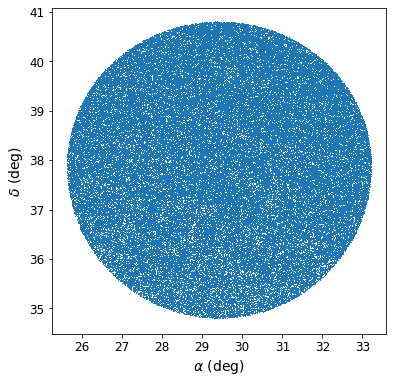

In [14]:
fig = plt.figure(figsize=(6, 6))
plt.plot(data['ra'], data['dec'], ',')

plt.xlabel(r'$\alpha$ (deg)')
plt.ylabel(r'$\delta$ (deg)')

plt.show()

Vector Point Diagram

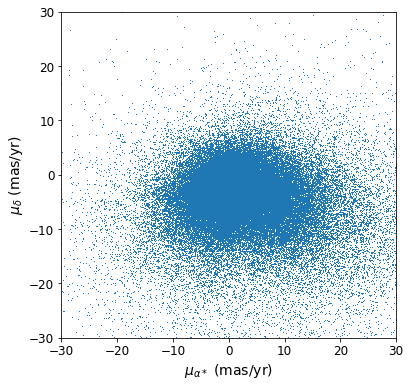

In [15]:
fig = plt.figure(figsize=(6, 6))
plt.plot(data['pmra'], data['pmdec'], ',')

plt.xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')

plt.xlim(-30,30)
plt.ylim(-30,30)

plt.show()

Color Magnitude Diagram

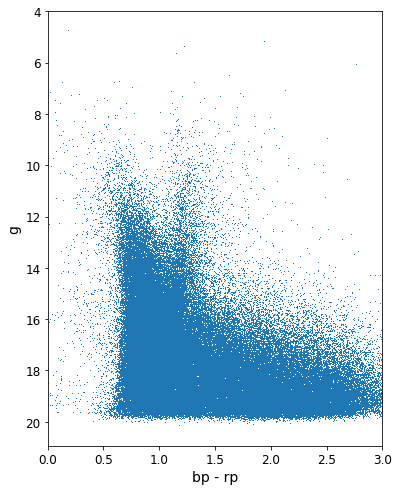

In [16]:
fig = plt.figure(figsize=(6, 8))
plt.plot(data['bp_rp'], data['phot_g_mean_mag'], ',')

ax = plt.gca()
ax.invert_yaxis()
plt.xlim(0., 3.)

plt.xlabel('bp - rp')
plt.ylabel('g')

plt.show()

---


####Here We Go!

Normalize the data

In [17]:
stscaler_df = StandardScaler().fit(df)
df_ = stscaler_df.transform(df)

Run HDBSCAN

In [19]:
from collections import Counter

In [20]:
clus_size = 2 * df_.shape[1]

In [21]:
clusterer = hdbscan.HDBSCAN(clus_size)
cluster_labels = clusterer.fit_predict(df_)

data['hdbscan'] = cluster_labels

In [22]:
Counter(cluster_labels)

Counter({-1: 117622,
         1461: 10,
         907: 7,
         2515: 6,
         1373: 8,
         1576: 15,
         1763: 12,
         2760: 15,
         825: 10,
         197: 36,
         1992: 41,
         1271: 16,
         1066: 9,
         2720: 13,
         1407: 6,
         475: 15,
         1899: 9,
         1200: 31,
         118: 12,
         119: 10,
         1747: 27,
         2460: 36,
         554: 6,
         738: 10,
         1412: 26,
         1795: 24,
         1997: 19,
         1326: 13,
         527: 7,
         867: 7,
         710: 10,
         1547: 13,
         619: 18,
         1598: 20,
         495: 16,
         2407: 48,
         555: 9,
         2050: 12,
         2671: 13,
         2360: 14,
         52: 9,
         1478: 8,
         1442: 14,
         745: 7,
         2550: 17,
         1804: 39,
         646: 12,
         1100: 8,
         836: 9,
         893: 32,
         2649: 56,
         352: 12,
         608: 8,
         2650: 16,
         1

In [21]:
data['hdbscan']

0           -1
1           -1
2           -1
3         1461
4           -1
          ... 
152445      -1
152446     231
152447      -1
152448      -1
152449      -1
Name: hdbscan, Length: 152450, dtype: int64

Check each clustering result. The color bar in the image shows the label of each cluster obtained.

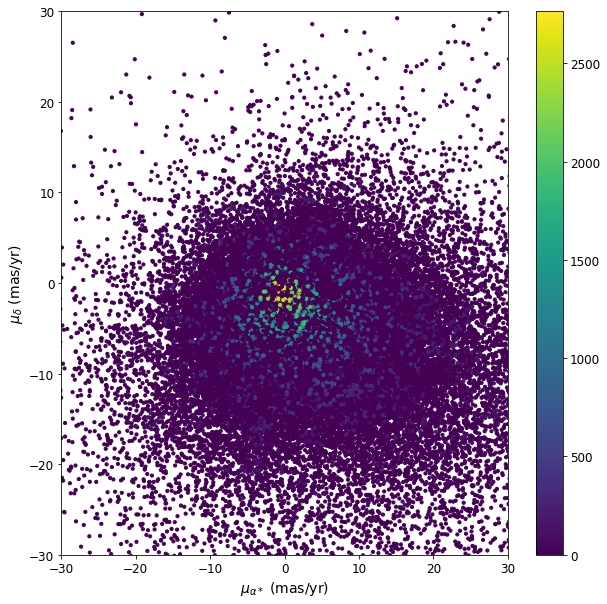

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
gr = ax.scatter(data['pmra'], data['pmdec'], s=10, c=cluster_labels, edgecolor=None)

fig.colorbar(gr, ax=ax)
ax = plt.gca()
ax.invert_yaxis()
plt.xlim(-30,30)
plt.ylim(-30,30)

plt.xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')

plt.show()

Distribution of group labels of all data.

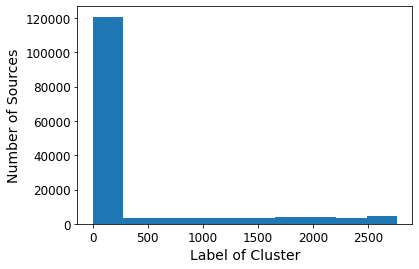

In [24]:
plt.figure(figsize=(6, 4))
plt.hist(data['hdbscan'])
plt.xlabel('Label of Cluster')
plt.ylabel('Number of Sources')
plt.show()

The number of members from each clustering result.

In [25]:
data['hdbscan'].value_counts()

-1       117622
 268        395
 2762       197
 2692        80
 2034        70
          ...  
 871          6
 1722         6
 1689         6
 2439         6
 2479         6
Name: hdbscan, Length: 2768, dtype: int64

Separate the data with a label that shows the background data (`label = -1`).

In [27]:
result_hdbscan = data[data['hdbscan'] >= 0].reset_index(drop=True)

c = result_hdbscan['hdbscan'].value_counts()

Find the cluster with the most number. Assuming the data used only consists of the background and one stellar cluster.

In [29]:
c

268     395
2762    197
2692     80
2034     70
2648     64
       ... 
200       6
105       6
1829      6
1579      6
2664      6
Name: hdbscan, Length: 2767, dtype: int64

In [30]:
n_max = c.index[np.argmax(c)]

result = data[data['hdbscan'] == n_max]

In [33]:
result

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pm,pmra,pmra_error,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,dr2_radial_velocity,dr2_radial_velocity_error,e_Gmag,e_BPmag,e_RPmag,bp_rp,hdbscan
1909,318223202227962624,27.567768,0.020226,35.358811,0.015459,1.953406,0.018973,14.671955,10.506126,0.025930,...,29994.006218,26.010920,13.555309,NaN,NaN,0.000259,0.001531,0.000942,1.311299,268
2004,318232853018089472,27.202517,0.226145,35.396360,0.205579,2.112153,0.275491,16.120638,10.750215,0.281643,...,837.378233,13.373943,17.440592,NaN,NaN,0.002683,0.136288,0.017341,2.552444,268
2998,318269961536387328,27.795180,0.224002,35.780506,0.219248,2.044952,0.274284,15.193239,10.322385,0.324488,...,638.378015,16.325256,17.735200,NaN,NaN,0.003243,0.124420,0.027766,2.485196,268
3523,318292089207130752,27.198466,0.113398,35.723078,0.114192,2.056820,0.138073,15.080875,10.844782,0.145835,...,1396.187779,9.520344,16.885536,NaN,NaN,0.001875,0.072315,0.007403,2.590354,268
7723,344092885468413696,28.026777,0.325904,39.943058,0.364699,1.964481,0.379610,15.094495,8.891794,0.482864,...,551.489665,8.421601,17.894053,NaN,NaN,0.004848,0.110248,0.016580,2.886281,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150269,331319309132002048,32.775380,0.341085,36.789041,0.300278,2.213036,0.365988,14.425470,8.077764,0.449493,...,437.405365,11.874529,18.145685,NaN,NaN,0.004701,0.136227,0.029475,2.668831,268
150955,331377926845710848,32.957705,0.293492,37.164950,0.310720,2.472307,0.352328,14.736646,9.341748,0.379010,...,430.364323,9.729965,18.163305,NaN,NaN,0.004476,0.125624,0.024547,2.858650,268
151300,331387551869347840,32.580048,0.063802,37.177659,0.066849,2.289026,0.076279,15.050242,8.964860,0.086659,...,2896.214833,8.934103,16.093319,NaN,NaN,0.001076,0.016687,0.003349,2.183921,268
151702,331398856223257472,32.601528,0.117422,37.369684,0.112537,1.965220,0.132099,15.037616,8.570863,0.149609,...,1622.950449,11.726293,16.722132,NaN,NaN,0.001687,0.046496,0.007845,2.548473,268




---


####Visualization II (Result)

Spatial Distribution

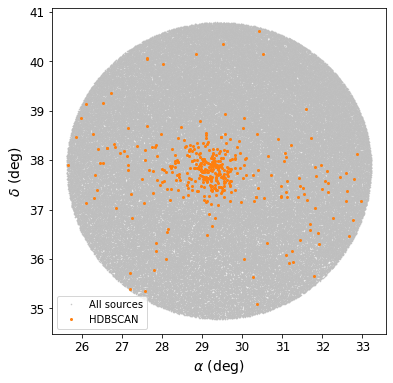

In [44]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
plt.plot(data['ra'], data['dec'], '.', mec='silver', mfc='darkgray', markersize=1., label="All sources")
plt.plot(result['ra'], result['dec'], 'o', mfc='tab:orange', markersize=2., label="HDBSCAN")

plt.xlabel(r'$\alpha$ (deg)')
plt.ylabel(r'$\delta$ (deg)')
plt.legend()
plt.show()

Vector Point Diagram

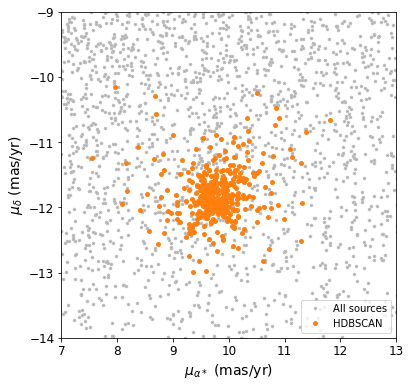

In [47]:
fig = plt.figure(figsize=(6, 6))
plt.plot(data['pmra'], data['pmdec'], '.', mec='silver', mfc='darkgray', markersize=5., label="All sources")
plt.plot(result['pmra'], result['pmdec'], 'o', mfc='tab:orange', mec='None', markersize=5., label="HDBSCAN")

plt.xlabel(r'$\mu_{\alpha*}$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')

plt.xticks()
plt.yticks()

plt.xlim(7,13)
plt.ylim(-14,-9)

plt.legend()
plt.show()

Color Magnitude Diagram

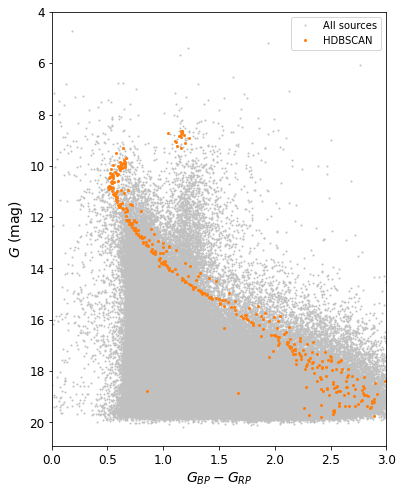

In [48]:
plt.figure(figsize=(6, 8))
plt.plot(data['bp_rp'], data['phot_g_mean_mag'], '.', mec='silver', mfc='darkgray', markersize=2., label="All sources")
plt.plot(result['bp_rp'], result['phot_g_mean_mag'], 'o', color='tab:orange', markersize=2., label=r"HDBSCAN")

plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$G$ (mag)')

plt.xlim(0., 3.)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Parallax Distribution

In [49]:
bins_all = np.arange(data['parallax'].min(), data['parallax'].max(), .01)
bins_sam = np.arange(result['parallax'].min(), result['parallax'].max(), .01)

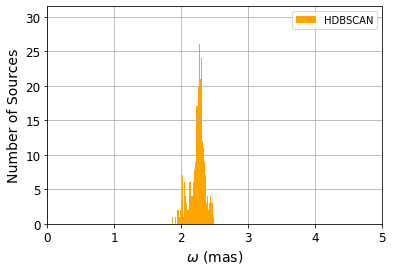

In [51]:
plt.figure(figsize=(6, 4))
#data.parallax.hist(bins=bins_all, color='gray', label="All Sources")
result.parallax.hist(bins=bins_sam, color='orange', label="HDBSCAN")

plt.xlabel(r'$\omega$ (mas)')
plt.ylabel('Number of Sources')

plt.xlim(0, 5)

plt.xticks()
plt.yticks()

plt.legend()
plt.show()

In [57]:
bins_sam = np.arange(result['pmra'].min(), result['pmra'].max(), .01)

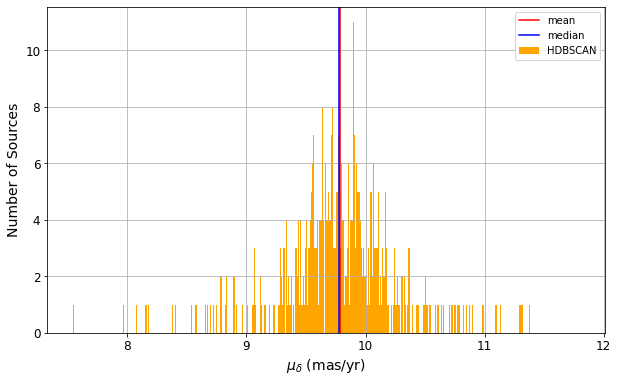

In [78]:
plt.figure(figsize=(10, 6))
#data.parallax.hist(bins=bins_all, color='gray', label="All Sources")
hist_pmra=result.pmra.hist(bins=bins_sam, color='orange', label="HDBSCAN")

plt.axvline(np.mean(result.pmra),color='red',label='mean')
plt.axvline(np.median(result.pmra),color='blue',label='median')

plt.xlabel(r'$\mu_{\delta}$ (mas/yr)')
plt.ylabel('Number of Sources')

#plt.xlim(0, 5)

plt.xticks()
plt.yticks()

plt.legend()
plt.show()



---


####Tasks

In [75]:
np.mean(result.pmra)

9.782790437718138

1. Determine the center of the stellar cluster

In [79]:
ra_c    = np.mean(result.ra)
dec_c   = np.mean(result.dec)
pmra_c  = np.mean(result.pmra)
pmdec_c = np.mean(result.pmdec)

In [80]:
print('ra_c    = ',np.mean(result.ra))
print('dec_c   = ',np.mean(result.dec))
print('pmra_c  = ',np.mean(result.pmra))
print('pmdec_c = ',np.mean(result.pmdec))

ra_c    =  29.24811484101642
dec_c   =  37.74211493998658
pmra_c  =  9.782790437718138
pmdec_c =  -11.784769357220727


2. You can also try with other data!
* M 67 = [gaiaedr3_150_M67.csv](https://drive.google.com/file/d/1eX41_G_W1eP3-9Qxi0OzM-BAIQOAQjbU/view?usp=sharing) <br>
* NGC 7789 = [gaiaedr3_45_NGC7789.csv](https://drive.google.com/file/d/12TAgIMdPgFUTtpL2jely0Y7umQCRhcEy/view?usp=sharing)




###Part 2: [Determine the Membership Probability](https://colab.research.google.com/drive/1ahHMhaKsnfNSyM4_kutjG-y1hv26s2XP?usp=sharing)

## 6. References

1. Agarwal, Manan, et al. "ML-MOC: Machine Learning (kNN and GMM) based Membership determination for Open Clusters." Monthly Notices of the Royal Astronomical Society 502.2 (2021): 2582-2599.
2. Campello, Ricardo JGB, et al. "Hierarchical density estimates for data clustering, visualization, and outlier detection." ACM Transactions on Knowledge Discovery from Data (TKDD) 10.1 (2015): 1-51.
3. Chen, W. P., C. W. Chen, and C. G. Shu. "Morphology of Galactic open clusters." The Astronomical Journal 128.5 (2004): 2306.
4. Ester, Martin, et al. "A density-based algorithm for discovering clusters in large spatial databases with noise." kdd. Vol. 96. No. 34. 1996.
5. Gaia Collaboration. "VizieR Online Data Catalog: Gaia DR2 (Gaia Collaboration, 2018)." VizieR Online Data Catalog (2018): I-345.
6. Kounkel, Marina, and Kevin Covey. "Untangling the Galaxy. I. Local Structure and Star Formation History of the Milky Way." The Astronomical Journal 158.3 (2019): 122.
7. McInnes, Leland, John Healy, and Steve Astels. "hdbscan: Hierarchical density based clustering." Journal of Open Source Software 2.11 (2017): 205.
8. Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python." the Journal of machine Learning research 12 (2011): 2825-2830.










